# Анализ заказов СберМаркета
# Выполнил: Швецов Максим

## Подключение к БД

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cr = pd.read_json('credentials.json', typ = 'series')

engine = sa.create_engine(
    f'postgresql://{cr.user}:{cr.password}@{cr.host}:{cr.port}/{cr.dbname}')

db = engine.connect()

### Тест подключения

In [3]:
query = '''
SELECT *
  FROM orders
 LIMIT 5
'''
df = pd.read_sql(query,db)
df.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,756927,139676,0.0,0.0,5015,0.0,37708,39,shipped,2018-08-26 15:01:42,2018-08-26 02:06:55,888330,1,226459
1,756963,139682,0.0,0.0,7096,0.0,49435,71,shipped,2018-08-26 16:28:41,2018-08-26 05:43:20,888394,1,226460
2,756983,63967,299.0,299.0,2724,-250.0,11590,32,shipped,2018-08-26 15:09:11,2018-08-26 06:12:13,888420,1,226459
3,756985,139687,0.0,0.0,3471,0.0,9915,13,shipped,2018-08-26 18:57:01,2018-08-26 06:13:59,888422,1,226462
4,757066,119006,299.0,299.0,1254,0.0,15022,24,shipped,2018-08-26 13:46:48,2018-08-26 07:40:58,870688,1,226458


---

## Анализ роста количества заказов за весь период

### Посмотрим на динамику количества заказов по месяцам:

In [4]:
query = '''
SELECT to_char(DATE_TRUNC('month', created_at), 'YYYY-MM') AS date,
       COUNT(*) AS orders_count
  FROM orders
 GROUP BY date
 ORDER BY date
'''
df = pd.read_sql(query, db)

<AxesSubplot:ylabel='orders'>

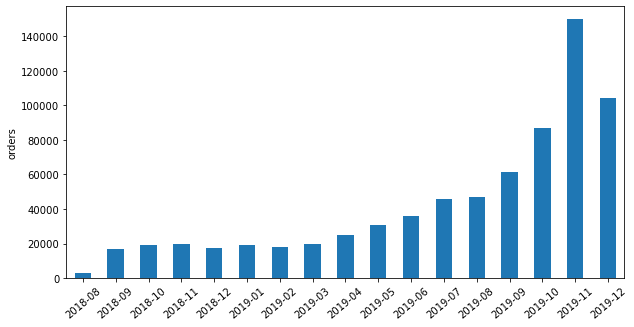

In [5]:
df.plot('date', 'orders_count', kind='bar', figsize=(10,5), legend=False, rot=40, ylabel='orders', xlabel='')

### И сразу построим график процентного отношения роста заказов текущего месяца к предыдущему:

<AxesSubplot:ylabel='%'>

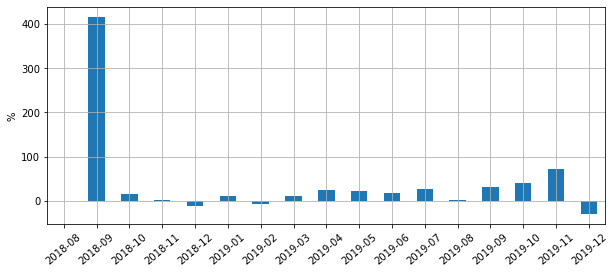

In [6]:
df['orders_diff'] = (df.orders_count / df.orders_count.shift() - 1) * 100 

df.plot('date', 'orders_diff', kind='bar', figsize=(10,4), legend=False, rot=40, ylabel='%', xlabel='', grid=True)

Зафиксируем четырёхкратный рост в сентябре 2018 и исключим его из графика для большей детализации.

<AxesSubplot:ylabel='%'>

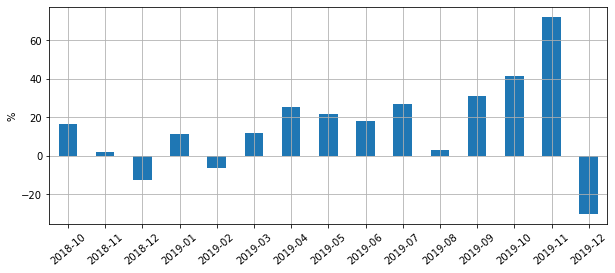

In [7]:
df.query('date > "2018-09"').plot('date', 'orders_diff', kind='bar', figsize=(10,4), legend=False, rot=40, ylabel='%', xlabel='', grid=True)

### На графиках прослеживаются определённые тенденции:

1. Интенсивный рост в сентябре 2018
2. Стабильный 20-ти процентный рост заказов начиная с марта 2019
3. Заметное увеличение объёма заказов в период с сентября по ноябрь 2019
4. Пик роста в ноябре 2019
5. Просадка в декабре 2019

### Попробуем разобраться, с чем они связаны:


#### 1. Интенсивный рост в сентябре 2018  
Тут наложились два фактора:  
- Выход сервиса в регионы: [новость от 31 июля 2018][kazan]
- Конец сезона отпусков
   
#### 2. Стабильный 20-ти процентный рост заказов начиная с марта 2019
- Расширение партнёрства с Metro Cash & Carry. [vc.ru][metro_vc], [retail.ru][metro_retail]  
  Все заказы на доставку с сайта Metro теперь перенаправляются в Instamart.  
- Инвестиции от Mail.ru Group и продолжение экспансии в регионы. [vedomosti.ru][mail_ru]

#### 3. Заметное увеличение объёма заказов в период с сентября по ноябрь 2019
- Инвестиции от Сбербанка [vc.ru][sber_invest]
- Тестовый запуск СберМаркета в Ростове-на-Дону и Краснодаре. [vc.ru][sbermarket_test]

#### 4. Пик роста в ноябре 2019
- Переименование Instamart в "СберМаркет" [vc.ru][rebrending]  
  Такое событие наверняка сопровождалось масштабной рекламной кампанией

#### 5. Просадка в декабре 2019
- Скорее всего произошёл откат к стабильным значениям после рекламной кампании


### Выводы
- Стабильный рост числа заказов обеспечен экспансией в регионы
- Партнёрство с известными компаниями приводит к расширению аудитории потенциальных пользователей 

[kazan]: https://www.vedomosti.ru/business/articles/2018/07/31/776990-instamart
[metro_vc]: https://vc.ru/trade/59574-metro-zapustila-internet-magazin-s-dostavkoy-na-dom-cherez-instamart
[metro_retail]: https://www.retail.ru/news/metro-i-instamart-rasshiryayut-strategicheskoe-partnerstvo/
[mail_ru]: https://www.vedomosti.ru/business/articles/2019/04/01/797979-instamart-privlek
[sber_invest]: https://vc.ru/finance/79124-fond-s-investiciyami-ot-sberbanka-stal-akcionerom-servisa-dostavki-produktov-instamart-vmesto-lva-hasisa
[sbermarket_test]: https://vc.ru/trade/82040-sberbank-zapustil-testirovanie-servisa-dostavki-produktov-iz-magazinov-sbermarket
[rebrending]: https://vc.ru/trade/92492-servis-dostavki-produktov-iz-magazinov-instamart-smenit-nazvanie-na-sbermarket

---

## Анализ сезонности внутри дня / недели

### Посмотрим на график интенсивности создания заявок в течении дня

In [8]:
query = '''
SELECT TO_CHAR(created_at, 'HH24') AS hours,
       COUNT(*) AS orders_rate
  FROM orders
 GROUP BY hours
 ORDER BY hours
'''
df = pd.read_sql(query, db)

<AxesSubplot:xlabel='hours', ylabel='orders'>

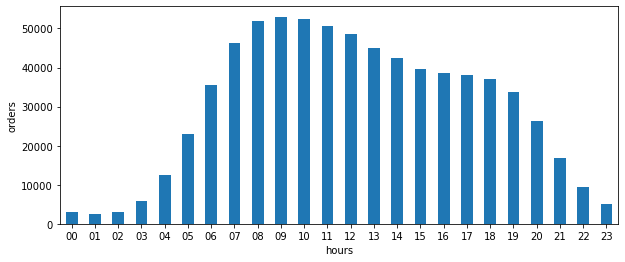

In [9]:
df.plot('hours', 'orders_rate', kind='bar', figsize=(10,4), legend=False, rot=0, ylabel='orders')

Наблюдается рост заказов в период с 6 до 15 часов.  
_(Напоминает легендарного удава, который проглотил слона: [pic])_

#### Теперь посмотрим на распределение частоты выбора интервалов времени доставки:


[pic]: https://avatars.mds.yandex.net/get-zen_doc/1542444/pub_5c6f94964f807500aeb4541a_5c6fd4cc0708ca00c1d488fe/scale_1200

In [10]:
query = '''
SELECT EXTRACT(HOURS FROM starts_at) AS hours,
       COUNT(*) AS rate
  FROM delivery_windows
 GROUP BY hours
 ORDER BY hours
'''
df = pd.read_sql(query, db)

<AxesSubplot:xlabel='hours'>

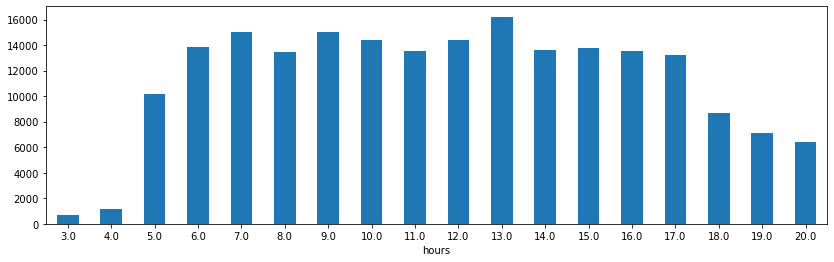

In [11]:
df.plot('hours', 'rate', kind='bar', figsize=(14,4), legend=False, rot=0)

Видим относительно равномерное распределение временных интервалов в течении рабочего дня.

Учитывая, что самая ранняя доставка возможна с 6 утра, а первое окно начинается в 3 ночи,  
можно сделать вывод о том, что время в таблице хранится относительно одного часового пояса.  

Этим можно объяснить аномальный рост заказов в первой половине дня и просадку в вечерних интервалах доставки:  
Заказы из городов с одним часовым поясом накладываются на заказы с более поздним часовым поясом и получается такой горб.

### Проверим, есть ли сезонность внутри недели:

In [12]:
query = '''
SELECT TO_CHAR(created_at, 'ID Day') AS day_of_week,
       COUNT(*) AS count
  FROM orders
 GROUP BY day_of_week
 ORDER BY day_of_week
'''
df = pd.read_sql(query, db)

<AxesSubplot:>

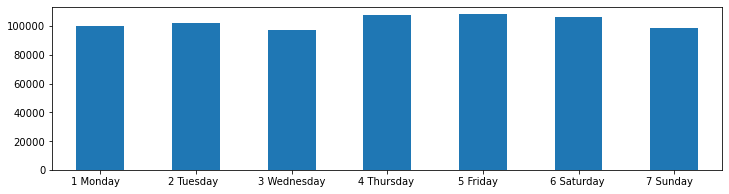

In [13]:
df.plot('day_of_week', 'count', kind='bar', figsize=(12,3), legend=False, rot=0, xlabel='')

Равномерное распределение значений.  
Сезонность не наблюдается.

### Выводы
- Сезонность заказов внутри дня соответствует,  
  а рост заказов в дневное время обусловлен нахождением городов в разных часовых поясах.
- Сезонность внутри недели отсутствует

---

## Анализ частоты повторных заказов

### Посмотрим, с каким интервалом пользователи чаще всего делают повторный заказ:  
(Выборку ограничим 37 днями)

In [14]:
query = '''
  WITH orders_delay AS (
      SELECT user_id,
             ROUND(EXTRACT(
                           EPOCH FROM created_at - LAG(created_at)
                                                   OVER (PARTITION BY user_id
                                                       ORDER BY created_at)
                       ) / 3600 / 24) AS days_gap

        FROM orders)

SELECT days_gap,
       COUNT(*) AS amount
  FROM orders_delay
 WHERE days_gap <= 37
 GROUP BY days_gap
 ORDER BY days_gap
'''
df = pd.read_sql(query, db)

<AxesSubplot:xlabel='days_gap', ylabel='orders'>

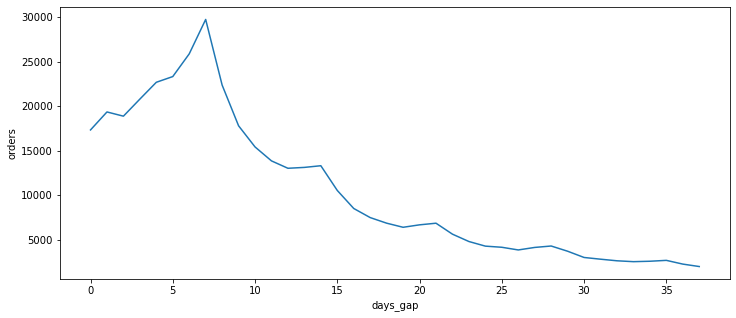

In [15]:
df.plot('days_gap', 'amount', figsize=(12,5), legend=False, ylabel='orders')

In [16]:
top_3 = df['amount'].sort_values(ascending=False).head(3)
df[df['amount'].isin(top_3)].sort_values('amount', ascending=False)

,days_gap,amount
7,7.0,29765
6,6.0,25896
5,5.0,23344


Как видим, наибольшее количество повторных заказов приходится на первые 10 дней с пиком в 7-ой день

Также можно заметить **волнообразность** графика - повторяющиеся возрастания значений относительно предыдущих, начиная с 7-го дня.  

### Найдём пики этих колебаний:

<AxesSubplot:xlabel='days_gap', ylabel='orders'>

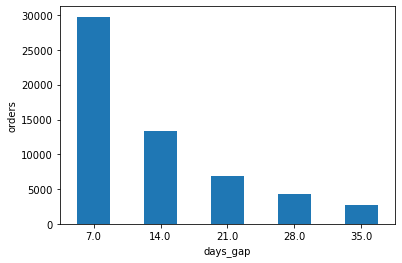

In [17]:
gap_peaks = df[(df.days_gap >= 7) 
               & (df.amount.diff() > 0)
               & (df.amount.diff(periods=-1) > 0)][['days_gap', 'amount']].copy()
gap_peaks.plot('days_gap', 'amount', kind='bar', legend=False, ylabel='orders', rot=0)

Судя по графику, на каждый 7-ой день приходится относительный рост числа повторных заказов.

Учитывая, что недельная сезонность отсутствует - это довольно занимательный факт.  
Возможно, это связано с периодичностью пуш-уведомлений с предложением воспользоваться сервисом ещё раз.  

### Предположим, что так оно и есть, и оценим эффективность таких уведомлений:

Для начала сымитируем отсутствие скачков каждые 7 дней.  
Найдём для них среднее значение между двумя предыдущими и двумя последующими днями:

<AxesSubplot:xlabel='days_gap', ylabel='orders'>

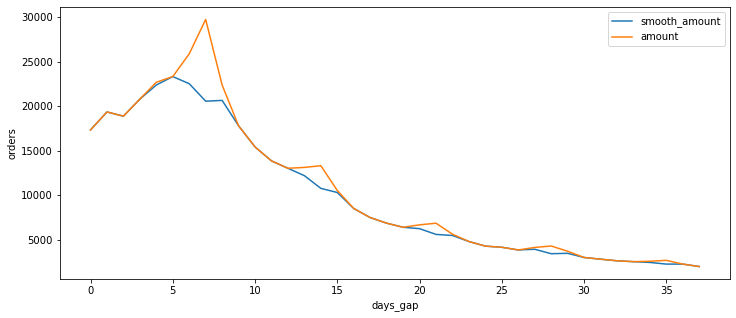

In [18]:
df['smooth_amount'] = df.amount.combine((df.amount.shift(2) + df.amount.shift(-2)) / 2, min)

df.plot('days_gap', ['smooth_amount', 'amount'], figsize=(12,5), ylabel='orders')

Перенесём полученные усреднённые значения в таблицу с пиками колебаний:

<AxesSubplot:xlabel='days_gap', ylabel='orders'>

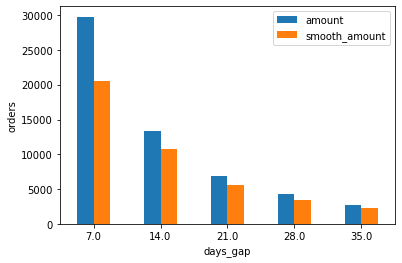

In [19]:
gap_peaks['smooth_amount'] = df.loc[gap_peaks.days_gap, 'smooth_amount']
gap_peaks.plot('days_gap', ['amount', 'smooth_amount'], kind='bar', ylabel='orders', xlabel='days_gap', rot=0)

Сделаем допущение, что пик в 7-й день - это естественное поведение пользователей, и не будем учитывать его в расчетах.  
Найдём процент прироста заказов по каждому дню:

<AxesSubplot:xlabel='days_gap', ylabel='%'>

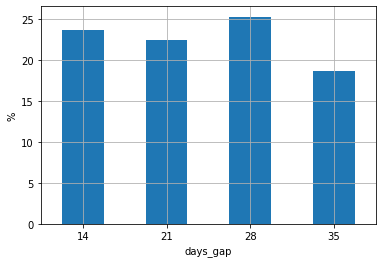

In [20]:
gap_peaks.drop(7, inplace=True)
gap_peaks['increase_rate'] = (gap_peaks.amount / gap_peaks.smooth_amount - 1) * 100
gap_peaks.increase_rate.plot(kind='bar', ylabel='%', xlabel='days_gap', rot=0, grid=True)

Найдём среднее процентов эффективности:

In [21]:
m = gap_peaks.increase_rate.mean()
round(m, 1)

22.5

### Выводы
- Наибольшее количество повторных заказов приходится на первые 10 дней с пиком в 7-ой день  
- С периодичностью в 7 дней происходит относительный рост частоты повторных заказов  
- Средний прирост заказов в эти дни составляет 22.5% относительно ожидаемых значений

---

## Аномалии в данных

### Заказы с нулевым количеством позиций (total_quantity): 26 записей

In [22]:
query = '''
SELECT *
  FROM orders
 WHERE total_quantity = 0
'''
df = pd.read_sql(query, db)
df.head()

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,2448854,416726,0.0,0.0,828,0.0,0,0,shipped,2019-09-24 10:47:04,2019-09-23 15:44:52,3502543,1,732746
1,3647822,1356962,299.0,299.0,419,0.0,0,0,shipped,2019-11-09 17:09:15,2019-11-06 16:32:52,5016159,1,846421
2,3716542,1226832,158.0,199.0,1116,0.0,0,0,shipped,2019-11-08 17:54:58,2019-11-07 14:41:16,4515332,1,843901
3,2096518,770814,0.0,299.0,745,0.0,0,0,shipped,2019-08-31 15:44:04,2019-08-25 17:07:55,2942122,3,686728
4,840797,162644,0.0,0.0,710,0.0,0,0,shipped,2018-10-11 06:21:01,2018-10-08 18:25:38,1036194,3,272184


Распределение по дате:

<AxesSubplot:ylabel='rate'>

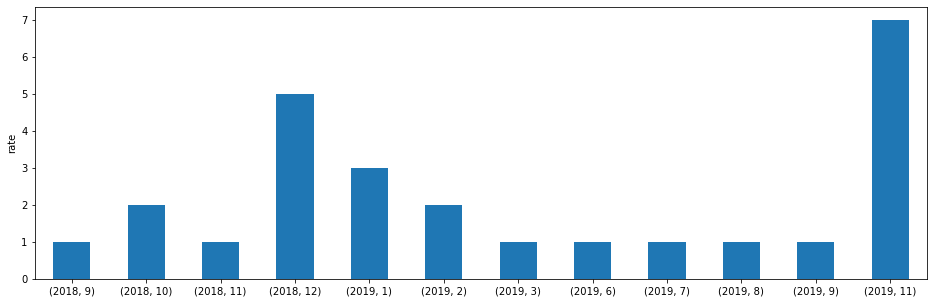

In [23]:
df.groupby([df['created_at'].dt.year, 
            df['created_at'].dt.month]).id.count().plot(kind='bar', figsize=(16,5), 
                                                        xlabel='', ylabel='rate', rot=0)

In [24]:
df.id.count()

26

Из них отменённых заказов - 16:

In [25]:
query = '''
SELECT DISTINCT id, user_id
  FROM orders
       JOIN cancellations c ON orders.id = c.order_id
 WHERE total_quantity = 0
'''
df = pd.read_sql(query, db)
df

,id,user_id
0,798216,150621
1,840797,162644
2,854444,166452
3,920748,181130
4,999722,207636
5,1016662,207482
6,1018400,212987
7,1018848,207482
8,1018850,207482
9,1026936,215744


Из них - 3 заказа от одного пользователя

In [26]:
df.groupby('user_id').id.count().sort_values(ascending=False)

user_id
207482    3
96623     1
150621    1
162644    1
166452    1
181130    1
207636    1
212987    1
215744    1
216640    1
234096    1
248704    1
255119    1
256015    1
Name: id, dtype: int64

### Заказы с нулевым весом (total_weight): 340 записей

In [27]:
query = '''
SELECT *
  FROM orders
 WHERE total_weight = 0
'''
df = pd.read_sql(query, db)
df

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,772241,142609,0.0,0.0,4243,0.0,0,1,shipped,2018-09-04 16:32:18,2018-09-03 07:13:32,907928,1,234086
1,829404,159337,0.0,0.0,1230,0.0,0,1,shipped,2018-10-03 11:45:53,2018-10-03 06:55:24,1017171,1,258211
2,848467,164776,0.0,0.0,1638,-300.0,0,2,shipped,2018-10-13 08:32:47,2018-10-13 06:24:08,1049645,1,266769
3,867576,170085,0.0,299.0,2657,0.0,0,1,shipped,2018-10-24 16:44:35,2018-10-23 05:25:47,1081489,1,276525
4,872310,167775,199.0,199.0,22674,0.0,0,50,shipped,2018-10-25 20:40:59,2018-10-25 11:06:25,1067987,1,277558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,4636722,56017,99.0,99.0,27598,0.0,0,97,shipped,2019-12-05 11:34:04,2019-11-29 07:12:26,6123036,162,922564
336,4612438,56017,199.0,199.0,3622,0.0,0,29,shipped,2019-11-28 14:16:34,2019-11-28 13:45:17,6084139,163,900668
337,5324107,1578435,158.0,238.0,2269,0.0,0,20,shipped,2019-12-16 09:44:49,2019-12-15 16:29:01,6999152,259,965693
338,1217533,272363,0.0,0.0,5316,-250.0,0,1,shipped,2019-03-20 06:04:55,2019-03-19 15:03:47,1641627,108,439008


Распределение по пользователям (топ-10):

<AxesSubplot:xlabel='user_id', ylabel='rate'>

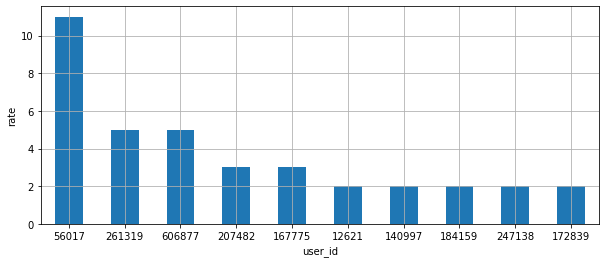

In [28]:
df.groupby('user_id').id.count().sort_values(ascending=False).head(10).plot(kind='bar', 
                                                        figsize=(10,4), 
                                                        xlabel='user_id', ylabel='rate', 
                                                        grid=True, rot=0)

Распределение по дате:

<AxesSubplot:ylabel='rate'>

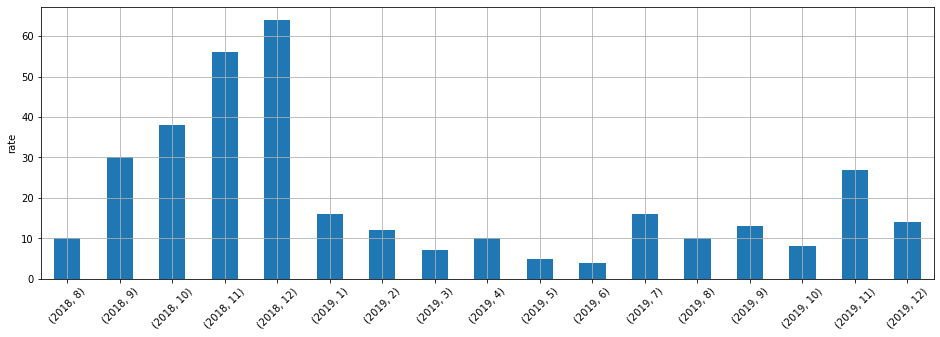

In [29]:
df.groupby([df['created_at'].dt.year, 
            df['created_at'].dt.month]).id.count().plot(kind='bar', 
                                                        figsize=(16,5), 
                                                        xlabel='', ylabel='rate', 
                                                        grid=True, rot=45)

### Заказы с нулевой суммой корзины (item_total): 9 записей

In [30]:
query = '''
SELECT *
  FROM orders
 WHERE item_total = 0
'''
df = pd.read_sql(query, db)
df

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
0,2457003,777240,0.0,0.0,0,0.0,500,4,shipped,2019-09-24 13:33:58,2019-09-24 10:10:43,3520882,1,732756
1,2828415,1112015,0.0,299.0,0,0.0,4625,13,shipped,2019-10-20 10:04:05,2019-10-18 20:58:03,4082440,2,796140
2,1631533,416183,0.0,299.0,0,0.0,18000,18,shipped,2019-06-21 14:17:06,2019-06-21 09:52:24,2213321,3,561538
3,5126949,1758530,98.0,249.0,0,-199.0,10950,11,shipped,2019-12-11 05:46:06,2019-12-10 20:02:23,6751812,12,943952
4,881444,173854,0.0,299.0,0,0.0,705,3,shipped,2018-10-30 05:50:49,2018-10-29 16:01:04,1104838,14,282229
5,3838920,1410293,199.0,199.0,0,0.0,5810,7,shipped,2019-11-11 09:12:57,2019-11-09 07:23:24,5203891,63,852220
6,1528533,353833,99.0,149.0,0,0.0,3723,16,shipped,2019-06-01 04:41:19,2019-05-30 15:04:09,1772737,108,530572
7,5004403,1727727,99.0,199.0,0,0.0,11771,18,shipped,2019-12-08 07:51:02,2019-12-08 03:53:15,6378487,169,932160
8,2094365,674612,0.0,0.0,0,0.0,3385,15,shipped,2019-08-25 17:24:13,2019-08-25 13:26:08,2938463,70,675904


Проверим на соответствие отменённым заказам:

In [31]:
query = '''
SELECT COUNT(*)
  FROM orders
       JOIN (SELECT DISTINCT order_id
               FROM cancellations) AS c ON orders.id = c.order_id
 WHERE item_total = 0

'''
df = pd.read_sql(query, db)
df

,count
0,6


6 из 9.  
Тем не менее, в таблице orders эти заказы находятся в статусе 'shipped', что не соответствует действительности.

### Выводы
- В данных стабильно присутствуют нулевые значения, которые должны быть больше нуля.  
  Возможно, какой-то магазин не поставляет эти параметры.
- Наблюдается корелляция нулевых значений по весу и кол-ву товаров в декабре 2018 года,  
  что может указывать на временный сбой системы.

---

## Анализ влияния отмен и возвратов на количество постоянных пользователей

Найдём долю постоянных пользователей среди всех и долю постоянных пользователей среди тех, кто отменял покупки  
и найдем разницу между этими соотношениями.

- Ограничим выборку до 6 месяцев (с января по июнь 2019 включительно)
- За постоянных пользователей будем считать тех, кто сделал не менее 6 заказов в выбранном интервале

In [32]:
query = '''
  WITH
      orders_clamped AS (
          SELECT id,
                 user_id
            FROM orders
           WHERE created_at BETWEEN '2019-01-01' AND '2019-07-01'),

      orders_with_cancellations AS (
          SELECT id, user_id
            FROM orders_clamped AS o
                 JOIN (SELECT DISTINCT order_id
                         FROM cancellations) AS c ON o.id = c.order_id),

      regular_users AS (
          SELECT user_id,
                 COUNT(*) AS amount
            FROM orders_clamped
           GROUP BY user_id
          HAVING COUNT(*) >= 6),

      regular_users_with_cancellations AS (
          SELECT user_id,
                 COUNT(*) AS amount
            FROM orders_with_cancellations
           GROUP BY user_id
          HAVING COUNT(*) >= 6)

SELECT (SELECT COUNT(*) FROM orders_clamped) AS all_users,
       (SELECT COUNT(*) FROM regular_users) AS regular_users,
       (SELECT COUNT(*) FROM orders_with_cancellations) AS user_with_c,
       (SELECT COUNT(*) FROM regular_users_with_cancellations) AS regular_users_with_c
'''
df = pd.read_sql(query, db)
df

,all_users,regular_users,user_with_c,regular_users_with_c
0,148941,5180,83359,2746


Найдём соотношение постоянных пользователей ко всей выборке:

In [33]:
all_users_ratio = df.regular_users[0] / df.all_users[0] * 100
print('Доля всех постоянных пользователей:', round(all_users_ratio, 2), '%', sep= '')

users_with_cancelations_ratio = df.regular_users_with_c[0] / df.user_with_c[0] * 100
print('Доля постоянных пользователей с отменами:', round(users_with_cancelations_ratio, 2), '%', sep= '')

cancelations_diff = (1 - users_with_cancelations_ratio / all_users_ratio) * 100
print('Разница: ', round(cancelations_diff, 2), '%', sep= '')

Доля всех постоянных пользователей:3.48%
Доля постоянных пользователей с отменами:3.29%
Разница: 5.28%


#### Разница: 5.28%
Проделаем то же самое для пользователей с заменами:

In [34]:
query = '''
  WITH
      orders_clamped AS (
          SELECT id,
                 user_id
            FROM orders
           WHERE created_at BETWEEN '2019-01-01' AND '2019-07-01'),

      orders_with_replacements AS (
          SELECT id, user_id
            FROM orders_clamped AS o
                 JOIN (SELECT DISTINCT order_id
                         FROM replacements) AS r ON o.id = r.order_id),

      regular_users_with_replacements AS (
          SELECT user_id,
                 COUNT(*) AS amount
            FROM orders_with_replacements
           GROUP BY user_id
          HAVING COUNT(*) > 5)

SELECT (SELECT COUNT(*) FROM orders_with_replacements) AS user_with_r,
       (SELECT COUNT(*) FROM regular_users_with_replacements) AS regular_users_with_r
'''
df = pd.read_sql(query, db)
df

,user_with_r,regular_users_with_r
0,67570,2214


Найдём их соотношения:

In [35]:
print('Доля всех постоянных пользователей: ', round(all_users_ratio, 2), '%', sep= '')

users_with_replacements_ratio = df.regular_users_with_r[0] / df.user_with_r[0] * 100
print('Доля постоянных пользователей с заменами: ', round(users_with_replacements_ratio, 2), '%', sep= '')

replacements_diff = (1 - users_with_replacements_ratio / all_users_ratio) * 100
print('Разница: ', round(replacements_diff, 2), '%', sep= '')

Доля всех постоянных пользователей: 3.48%
Доля постоянных пользователей с заменами: 3.28%
Разница: 5.79%


Найдём среднее между двумя разницами:

In [36]:
m = np.mean([replacements_diff, cancelations_diff])
round(m, 2)

5.53

### Выводы
- Отмены и замены товара **уменьшают** количество постоянных пользователей в среднем **на 5.53%**
- Разница между постоянными пользователями с **отменами** и без: **5.28%**
- Разница между постоянными пользователями с **заменами** и без: **5.79%**